# streamfunction_vorticity_pytorch_solvers

> Solvers based on the PyTorch package for the full Navier-Stokes equations in the streamfunction-vorticity form

In [ ]:
#| default_exp streamfunction_vorticity_pytorch

# Imports

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from uom_project import core

import numpy as np

import torch
import torch.nn.functional as F

In [ ]:
from uom_project import streamfunction_vorticity_newton

from functools import partial

from torch.func import jacfwd

from fastcore.test import test_eq

In [ ]:
newton_solver = streamfunction_vorticity_newton.newton_solver
f = streamfunction_vorticity_newton.f
get_jacobian = streamfunction_vorticity_newton.get_jacobian

# PyTorch solver

In [ ]:
#| exporti

# Given the vorticity, solve the Poisson eqn. to find the streamfunction
def f_pytorch(x, Re, U_wall_top):
    N = int(np.sqrt(x.shape[0] // 2 + 1))
    h = 1 / N

    psi = x[:(N-1)**2].reshape(N-1, N-1)
    w_left   = x[(N-1)**2 + 0*(N-1) : (N-1)**2 + 1*(N-1)][:, 0]
    w_right  = x[(N-1)**2 + 1*(N-1) : (N-1)**2 + 2*(N-1)][:, 0]
    w_bottom = x[(N-1)**2 + 2*(N-1) : (N-1)**2 + 3*(N-1)][:, 0]
    w_top    = x[(N-1)**2 + 3*(N-1) : (N-1)**2 + 4*(N-1)][:, 0]
    w_middle = x[(N-1)**2 + 4*(N-1) :].reshape(N-1, N-1)

    # Calculate the equations coming from the Poisson equation
    f_poisson = -4 * psi + h ** 2 * w_middle
    f_poisson[:-1, :] += psi[1:, :]
    f_poisson[1:, :] += psi[:-1, :]
    f_poisson[:, :-1] += psi[:, 1:]
    f_poisson[:, 1:] += psi[:, :-1]

    # Calculate the sides first
    # y = 0, U_wall = 0
    f_w_bottom = h ** 2 * (w_middle[:, 0] + 3 * w_bottom) + 8 * psi[:, 0]
    # y = 1, U_wall is known here
    f_w_top = h ** 2 * (w_middle[:, -1] + 3 * w_top) + 8 * (
        h * U_wall_top + psi[:, -1]
    )
    # x = 0
    f_w_left = h ** 2 * (w_middle[0, :] + 3 * w_left) + 8 * psi[0, :]
    # x = 1
    f_w_right = h ** 2 * (w_middle[-1, :] + 3 * w_right) + 8 * psi[-1, :]

    f_w_middle = -4 * w_middle
    f_w_middle[:-1, :] += w_middle[1:, :]
    f_w_middle[-1:, :] += w_right
    f_w_middle[1:, :] += w_middle[:-1, :]
    f_w_middle[:1, :] += w_left
    f_w_middle[:, :-1] += w_middle[:, 1:]
    f_w_middle[:, -1] += w_top
    f_w_middle[:, 1:] += w_middle[:, :-1]
    f_w_middle[:, 0] += w_bottom

    f_w_middle[1:-1, 1:-1] += Re * (
        (psi[2:, 1:-1] - psi[:-2, 1:-1]) * (w_middle[1:-1, 2:] - w_middle[1:-1, :-2]) -
        (psi[1:-1, 2:] - psi[1:-1, :-2]) * (w_middle[2:, 1:-1] - w_middle[:-2, 1:-1])
    ) / 4
    f_w_middle[:1, 1:-1] += Re * (
        psi[1, 1:-1] * (w_middle[0, 2:] - w_middle[0, :-2]) -
        (psi[0, 2:] - psi[0, :-2]) * (w_middle[1, 1:-1] - w_left[1:-1])
    ) / 4
    f_w_middle[-1:, 1:-1] -= Re * (
        psi[-2, 1:-1] * (w_middle[-1, 2:] - w_middle[-1, :-2]) +
        (psi[-1, 2:] - psi[-1, :-2]) * (w_right[1:-1] - w_middle[-2, 1:-1])
    ) / 4
    f_w_middle[1:-1, 0] += Re * (
        (psi[2:, 0] - psi[:-2, 0]) * (w_middle[1:-1, 1] - w_bottom[1:-1]) -
        psi[1:-1, 1] * (w_middle[2:, 0] - w_middle[:-2, 0])
    ) / 4
    f_w_middle[1:-1, -1] += Re * (
        (psi[2:, -1] - psi[:-2, -1]) * (w_top[1:-1] - w_middle[1:-1, -2]) +
        psi[1:-1, -2] * (w_middle[2:, -1] - w_middle[:-2, -1])
    ) / 4
    f_w_middle[0, 0] += Re * (
        psi[1, 0] * (w_middle[0, 1] - w_bottom[0]) -
        psi[0, 1] * (w_middle[1, 0] - w_left[0])
    ) / 4
    f_w_middle[-1, 0] -= Re * (
        psi[-2, 0] * (w_middle[-1, 1] - w_bottom[-1]) +
        psi[-1, 1] * (w_right[0] - w_middle[-2, 0])
    ) / 4
    f_w_middle[0, -1] += Re * (
        psi[1, -1] * (w_top[0] - w_middle[0, -2]) +
        psi[0, -2] * (w_middle[1, -1] - w_left[-1])
    ) / 4
    f_w_middle[-1, -1] -= Re * (
        psi[-2, -1] * (w_top[-1] - w_middle[-1, -2]) -
        psi[-1, -2] * (w_right[-1] - w_middle[-2, -1])
    ) / 4

    return torch.hstack([
        f_poisson.flatten(), f_w_left, f_w_right, f_w_bottom, f_w_top,
        f_w_middle.flatten()
    ])[:, None]


def reconstruct_w_pytorch(w_tmp, N, device):
    w = torch.zeros((N+1, N+1), device=device)

    w[:1, 1:-1] = w_tmp[0*(N-1):1*(N-1)].T
    w[-1:, 1:-1] = w_tmp[1*(N-1):2*(N-1)].T
    w[1:-1, :1] = w_tmp[2*(N-1):3*(N-1)]
    w[1:-1, -1:] = w_tmp[3*(N-1):4*(N-1)]
    w[1:-1, 1:-1] = w_tmp[4*(N-1):].reshape((N - 1, N - 1))

    return w


def newton_iterator_pytorch(
    f, get_jacobian, N, Re, U_wall_top, device,
    algorithm="base", TOL=1e-8, max_iter=10, quiet=True
):
    '''
        - f: evaluates the function given x, Re
        - get_jacobian: evaluates the Jacobian given N, h
        - N: number of grid points
        - h: grid size
        - Re: Reynolds number
    '''

    n_iter = 0 # number of iterations

    # Initialization
    # Size (N - 1) ** 2         + (N + 1) ** 2    - 4
    # Size (for streamfunction) + (for vorticity) - (corners of vorticity)
    x = torch.zeros(((N - 1) ** 2 + (N + 1) ** 2 - 4, 1), device=device).double()
    f_current = f(x=x, Re=Re, U_wall_top=U_wall_top)

    # Check if the initial guess is a solution
    f_norm = torch.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter

    while n_iter < max_iter:
        n_iter += 1
        jacobian = get_jacobian(x, Re, U_wall_top).squeeze()

        kwargs = {}
        if algorithm == "lstsq" and device.type == "cpu":
            kwargs["driver"] = "gels"
        dx = core.solve_sparse_linear_system_pytorch(
            A=jacobian, b=-f_current, algorithm=algorithm, **kwargs
        )
        x_next = x + dx

        f_current = f(x=x_next, Re=Re, U_wall_top=U_wall_top)

        f_norm = torch.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; residual={f_norm}; dx={torch.linalg.norm(dx)}")
        if f_norm <= TOL:
            break

        x = x_next

    if not quiet:
        print(f"n_iter={n_iter}")

    return x_next, n_iter


In [ ]:
#| export
def newton_solver_pytorch(
    f, get_jacobian, N, Re, U_wall_top, device,
    algorithm="base", TOL=1e-8, max_iter=10, quiet=True
):

    solution, n_iter = newton_iterator_pytorch(
        f=f, get_jacobian=get_jacobian, N=N, Re=Re, U_wall_top=U_wall_top,
        algorithm=algorithm, device=device,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )

    psi, w = solution[:(N - 1) ** 2], solution[(N - 1) ** 2:]

    # Get final psi
    psi = psi.reshape(N - 1, N - 1)
    psi = F.pad(psi, (1, 1, 1, 1), mode="constant", value=0)

    # Get final w
    w = reconstruct_w_pytorch(w_tmp=w, N=N, device=device)
    w = w.reshape(N + 1, N + 1)

    return w, psi, n_iter


In [ ]:
device = torch.device("cpu")

In [ ]:
N = 20
Re = 0 # i.e. viscosity mu = inf
U_wall_top = torch.sin(torch.pi * torch.arange(1, N, device=device) / N) ** 2

w, psi, _ = newton_solver(
    f=partial(f, U_wall_top=U_wall_top.numpy()),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False
)

w2, psi2, n_iter = newton_solver_pytorch(
    f=f_pytorch,
    get_jacobian=jacfwd(f_pytorch),
    U_wall_top=U_wall_top,
    device=device,
    N=N, Re=Re, quiet=False,
    algorithm="lu_solve",
)
test_eq(np.allclose(w, w2), True)
test_eq(np.allclose(psi, psi2), True)
test_eq(n_iter, 1)

iter=1; residual=1.7911801483628596e-14; dx=39.71450822732799
n_iter=1
iter=1; residual=2.1011348048587708e-14; dx=39.71450822732806
n_iter=1


In [ ]:
N = 20
Re = 10
U_wall_top = torch.sin(torch.pi * torch.arange(1, N, device=device) / N) ** 2

w, psi, _ = newton_solver(
    f=partial(f, U_wall_top=U_wall_top.numpy()),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False
)

w2, psi2, n_iter = newton_solver_pytorch(
    f=f_pytorch,
    get_jacobian=jacfwd(f_pytorch),
    U_wall_top=U_wall_top,
    device=device,
    N=N, Re=Re, quiet=False,
    algorithm="lu_solve",
)
test_eq(np.allclose(w, w2), True)
test_eq(np.allclose(psi, psi2), True)
test_eq(n_iter, 3)

iter=1; residual=1.083638203557906; dx=39.71450822732799
iter=2; residual=0.0015404929055467538; dx=2.273926787770746
iter=3; residual=8.799675190900906e-10; dx=0.0014642597246177327
n_iter=3
iter=1; residual=1.0836382035579217; dx=39.71450822732806
iter=2; residual=0.0015404929055476135; dx=2.2739267877708866
iter=3; residual=8.79969278773733e-10; dx=0.0014642597246035385
n_iter=3


In [ ]:
N = 20
Re = 10
U_wall_top = 1.0

w, psi, _ = newton_solver(
    f=partial(f, U_wall_top=U_wall_top),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False
)

w2, psi2, n_iter = newton_solver_pytorch(
    f=f_pytorch,
    get_jacobian=jacfwd(f_pytorch),
    U_wall_top=U_wall_top,
    device=device,
    N=N, Re=Re, quiet=False,
    algorithm="lu_solve",
)
test_eq(np.allclose(w, w2), True)
test_eq(np.allclose(psi, psi2), True)
test_eq(n_iter, 3)

iter=1; residual=5.302183624903517; dx=92.25374180247306
iter=2; residual=0.006521635545197795; dx=4.117563911077406
iter=3; residual=3.950959235746444e-09; dx=0.003689348557295655
n_iter=3
iter=1; residual=5.30218362490356; dx=92.25374180247339
iter=2; residual=0.006521635545205954; dx=4.117563911077487
iter=3; residual=3.950961348542755e-09; dx=0.003689348557313448
n_iter=3


In [ ]:
N = 20
Re = 10
U_wall_top = torch.sin(torch.pi * torch.arange(1, N, device=device) / N) ** 2

fun = partial(f, U_wall_top=U_wall_top.numpy())

In [ ]:
#| eval: false
%timeit newton_solver(f=fun, get_jacobian=get_jacobian, N=N, Re=Re)

1.24 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#| eval: false
%timeit newton_solver_pytorch(f=f_pytorch, get_jacobian=jacfwd(f_pytorch), U_wall_top=U_wall_top, device=device, N=N, Re=Re, algorithm="lu_solve")

332 ms ± 92.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#| eval: false
%timeit newton_solver_pytorch(f=f_pytorch, get_jacobian=jacfwd(f_pytorch), U_wall_top=U_wall_top, device=device, N=N, Re=Re, algorithm="lstsq")

345 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Test on GPU

In [ ]:
#| eval: false
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
if device.type == "cuda":
    N = 40
    Re = 10
    U_wall_top = torch.sin(torch.pi * torch.arange(1, N, device=device) / N) ** 2

    fun = partial(f, U_wall_top=U_wall_top.cpu().numpy())

    jac = jacfwd(f_pytorch)


In [ ]:
#| eval: false
if device.type == "cuda":
    %timeit newton_solver(f=fun, get_jacobian=get_jacobian, N=N, Re=Re)

2.92 s ± 437 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#| eval: false
if device.type == "cuda":
    %timeit newton_solver_pytorch(f=f_pytorch, get_jacobian=jac, U_wall_top=U_wall_top, device=device, N=N, Re=Re, algorithm="lu_solve")

517 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# PyTorch LBFGS solver

In [ ]:
def lbfgs_solver_pytorch(
    f, N, Re, U_wall_top, device, n_steps=100, line_search_fn=None, max_iter=20,
):
    solution = torch.zeros(
        ((N - 1) ** 2 + (N + 1) ** 2 - 4, 1), device=device, requires_grad=True,
    )
    optimizer = torch.optim.LBFGS(
        [solution], lr=1.0, max_iter=max_iter, line_search_fn=line_search_fn,
        tolerance_grad=1e-10,
    )

    loss_fn = lambda x, Re, U_wall_top: f(x, Re, U_wall_top).pow(2).sum()
    losses = []

    def closure():
        optimizer.zero_grad()

        loss = loss_fn(solution, Re, U_wall_top)
        loss.backward()

        losses.append(loss.detach())

        return loss

    for i in range(n_steps):
        optimizer.step(closure)

    losses = torch.tensor(losses).cpu()
    print(min(losses))

    solution = solution.detach()
    psi, w = solution[:(N - 1) ** 2], solution[(N - 1) ** 2:]

    # Get final psi
    psi = psi.reshape(N - 1, N - 1)
    psi = F.pad(psi, (1, 1, 1, 1), mode="constant", value=0)

    # Get final w
    w = reconstruct_w_pytorch(w_tmp=w, N=N, device=device)
    w = w.reshape(N + 1, N + 1)

    return w, psi, losses


In [ ]:
device = torch.device("cpu")

In [ ]:
#| eval: false
N = 20
Re = 10
U_wall_top = torch.sin(torch.pi * torch.arange(1, N, device=device) / N) ** 2

w, psi, _ = newton_solver(
    f=partial(f, U_wall_top=U_wall_top.cpu().numpy()),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False
)

w2, psi2, losses = lbfgs_solver_pytorch(
    f=f_pytorch, N=N, Re=Re, U_wall_top=U_wall_top,
    device=device,
    line_search_fn="strong_wolfe",
    n_steps=100, max_iter=20,
)
test_eq(np.allclose(w, w2.cpu()), False)
test_eq(np.allclose(psi, psi2.cpu()), False)

iter=1; residual=1.083638203557906; dx=39.71450822732799
iter=2; residual=0.0015404929055467538; dx=2.273926787770746
iter=3; residual=8.799675190900906e-10; dx=0.0014642597246177327
n_iter=3
tensor(0.0006)


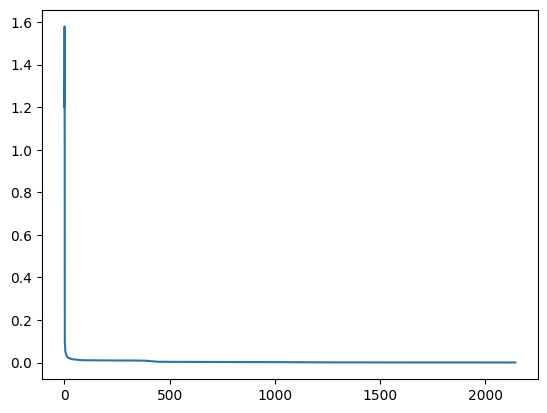

In [ ]:
#| eval: false
import matplotlib.pyplot as plt

plt.plot(losses);

In [ ]:
#| eval: false
np.abs(w-w2.cpu().numpy()).max(), np.abs(psi-psi2.cpu().numpy()).max()

(2.181970350966864, 0.004217433334225779)

In [ ]:
#| eval: false
((w-w2.cpu().numpy()) ** 2).mean(), ((psi-psi2.cpu().numpy()) ** 2).mean()

(0.20580520618887085, 2.8236501072078815e-06)

# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()